1. 自动求导

In [2]:
import torch

# 1. 创建带梯度追踪的张量（叶子节点）
x = torch.tensor([2.0, 3.0], requires_grad=True)
y = torch.tensor([1.0, 4.0], requires_grad=True)

# 2. 定义运算（构建计算图）
z = x * y + 3  # z = [2*1+3, 3*4+3] = [5, 15]

# 3. 反向传播（对标量求和后求导，避免非标量传参问题）
z_sum = z.sum()  # 先求和得到标量：5+15=20
z_sum.backward()  # 计算z_sum对x、y的梯度

# 4. 查看梯度
print("x的梯度：", x.grad)  # dz_sum/dx = y → [1.0, 4.0]
print("y的梯度：", y.grad)  # dz_sum/dy = x → [2.0, 3.0]
print("z的grad_fn：", z.grad_fn)  # 显示z的运算函数（AddBackward0）

x的梯度： tensor([1., 4.])
y的梯度： tensor([2., 3.])
z的grad_fn： <AddBackward0 object at 0x00000224D792EBF0>


2. 梯度清零与反向传播


In [3]:
import torch

# 重置张量
x = torch.tensor([2.0], requires_grad=True)

# 第一次反向传播
y1 = x **2
y1.backward()
print("第一次x的梯度：", x.grad)  # dy1/dx = 2x → 4.0

# 未清零直接第二次反向传播（梯度累积）
y2 = x** 3
y2.backward()
print("未清零第二次x的梯度：", x.grad)  # 4.0 + 3x²=4+12=16.0

# 清零后第三次反向传播
x.grad.zero_()  # 梯度清零
y3 = x * 5
y3.backward()
print("清零后第三次x的梯度：", x.grad)  # dy3/dx=5 → 5.0

第一次x的梯度： tensor([4.])
未清零第二次x的梯度： tensor([16.])
清零后第三次x的梯度： tensor([5.])


3. detach () 与 no_grad () 用法

In [11]:
import torch

x = torch.tensor([2.0], requires_grad=True)

# 使用detach()：分离张量，不追踪梯度
y = x.detach() * 3  # y的requires_grad=False
print("y的requires_grad：", y.requires_grad)  # False

# 使用no_grad()：上下文内不追踪梯度
with torch.no_grad():
    z = x **2
    print("z的requires_grad：", z.requires_grad)  # False

# 验证：detach/ no_grad不影响原张量的梯度追踪
# 修复点1：先执行反向传播，让x.grad有值；或先判断x.grad是否为None，再决定是否清零
w = x * 4
w.backward()
print("原张量x的梯度：", x.grad)  # 4.0（正常求导）

# 若需要再次反向传播，此时x.grad已有值，可安全清零
x.grad.zero_()
new_w = x * 5
new_w.backward()
print("清零后x的梯度：", x.grad)  # 5.0

y的requires_grad： False
z的requires_grad： False
原张量x的梯度： tensor([4.])
清零后x的梯度： tensor([5.])


4. 非标量张量反向传播（传入 gradient 参数）

In [7]:
import torch

x = torch.tensor([1.0, 2.0], requires_grad=True)
y = x * 2  # y = [2.0, 4.0]

# 非标量反向传播，需传入gradient参数（表示对y各维度的梯度权重）
y.backward(gradient=torch.tensor([1.0, 1.0]))  # 等价于对y.sum()求导
print("x的梯度：", x.grad)  # dy/dx=2 → [2.0, 2.0]

x的梯度： tensor([2., 2.])


5. 神经网络中的自动求导（实战场景）

In [8]:
import torch
import torch.nn as nn

# 定义简单神经网络
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)  # 线性层：y = wx + b

    def forward(self, x):
        return self.linear(x)

# 初始化模型、损失函数、优化器
model = SimpleNet()
criterion = nn.MSELoss()  # 均方误差损失
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 模拟数据
x = torch.tensor([[1.0], [2.0], [3.0]], requires_grad=False)
y_true = torch.tensor([[2.0], [4.0], [6.0]], requires_grad=False)

# 前向传播
y_pred = model(x)
loss = criterion(y_pred, y_true)

# 反向传播+优化
optimizer.zero_grad()  # 优化器梯度清零
loss.backward()  # 计算损失对模型参数的梯度
optimizer.step()  # 更新参数（使用梯度）

# 查看参数梯度
print("线性层权重梯度：", model.linear.weight.grad)
print("线性层偏置梯度：", model.linear.bias.grad)

线性层权重梯度： tensor([[-11.1042]])
线性层偏置梯度： tensor([-4.6773])


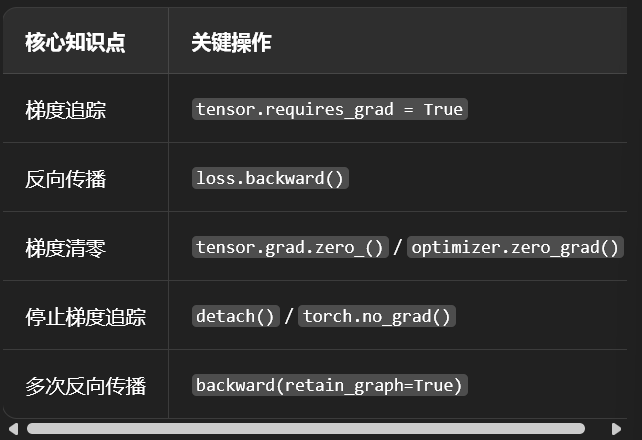